# Introduction

Abalone's age can be estimated counting the number of rings in their shell with a microscope, but it is a time consuming process. 
The goal of the project is to predict the rings of abalone based on some given features, sex and other physical measurements. linear regresion, knn, decision tree regressor and random forest regression is used to predict the number of rings.

### 1. Import data and libraries

In [58]:
import numpy as np
import pandas as pd
import os
import sys
import random
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
data = pd.read_csv("abalone_data.txt")
data.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [60]:
#check missing values
data.isnull().sum() 

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

### 2. Explore the dataset

#### 2.1 Visualize correlation

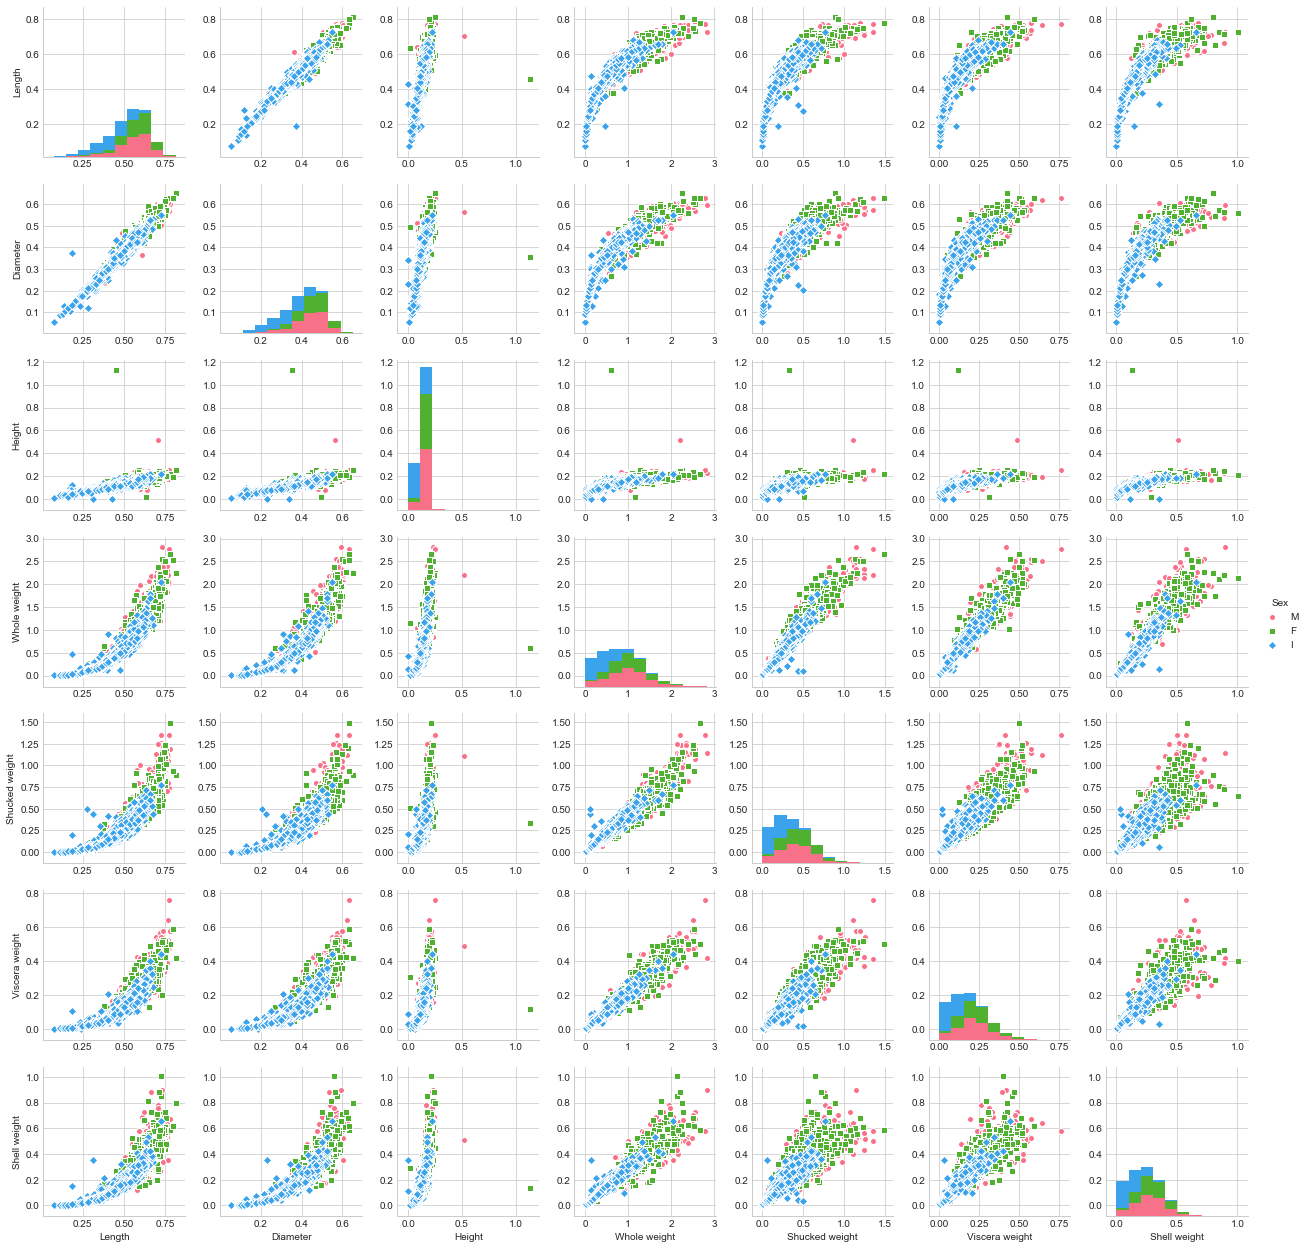

In [61]:
%matplotlib inline
#Observe colinearality between the features.
sns.pairplot(data.iloc[:,0:8],hue="Sex",palette="husl",markers=["o", "s", "D"])

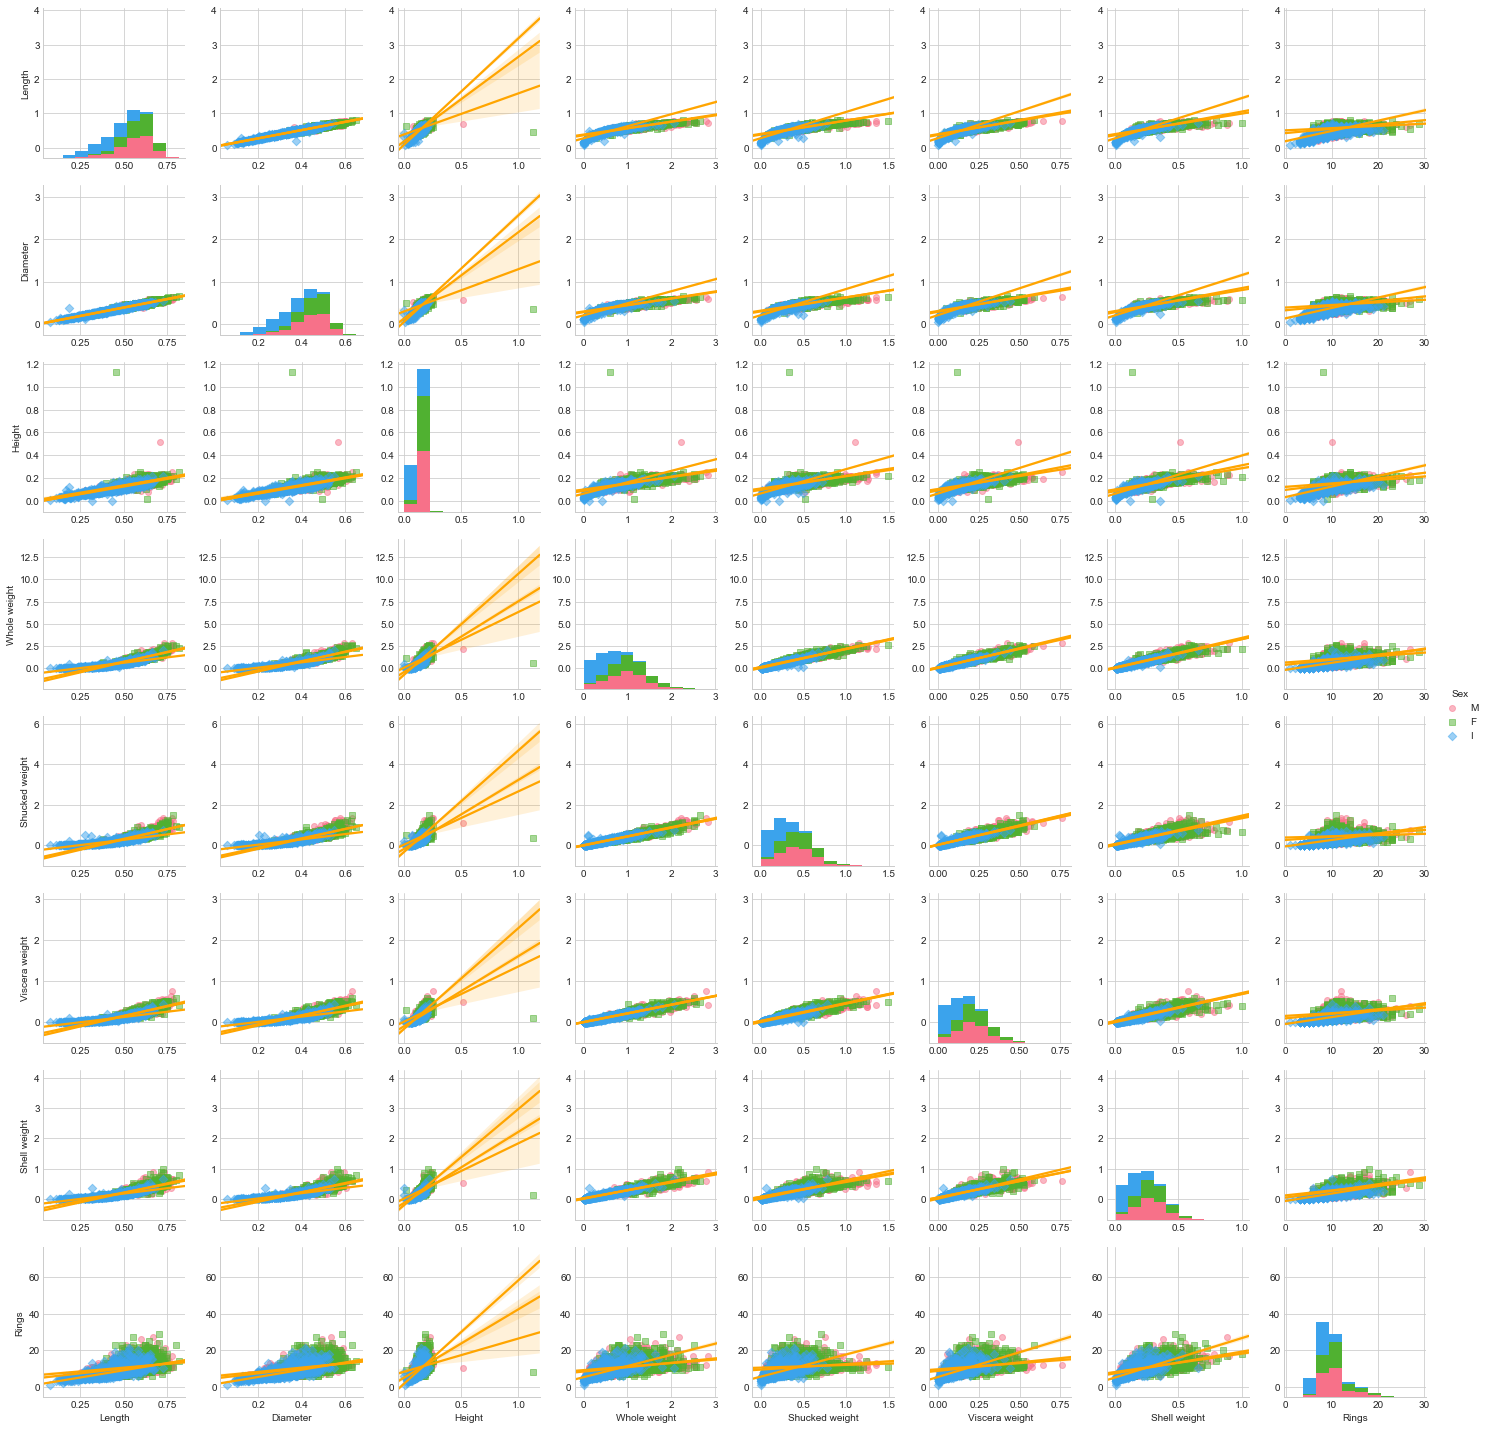

In [62]:
#Visualize pariwise correlation 
sns.pairplot(data,hue="Sex",palette="husl",markers=["o", "s", "D"],kind='reg',plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws': {'alpha': 0.5}}) 
plt.show()
%matplotlib inline

In [63]:
# correlation
data.corr()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


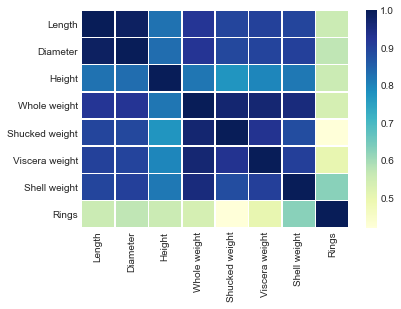

In [64]:
ax = sns.heatmap(data.corr(), linewidth=0.5,cbar=True,cmap="YlGnBu")
plt.figure(figsize = (12,7))
plt.show()

Observations: 

(1) Number of rings (age) is positively correlated with almost all the quantitative features. 

(2) Many features are highly correlated, for example, length & diameter is linearly correlated, length & all kinds of weight has a quadratic correlation, whole weight is linearlly correlated with shucked weight, viscera weight & shell weight. This could have an influence on the linear model. 

(3) Height has high variance.

(4) Rings has a correlation 0.62 with Shell weight.

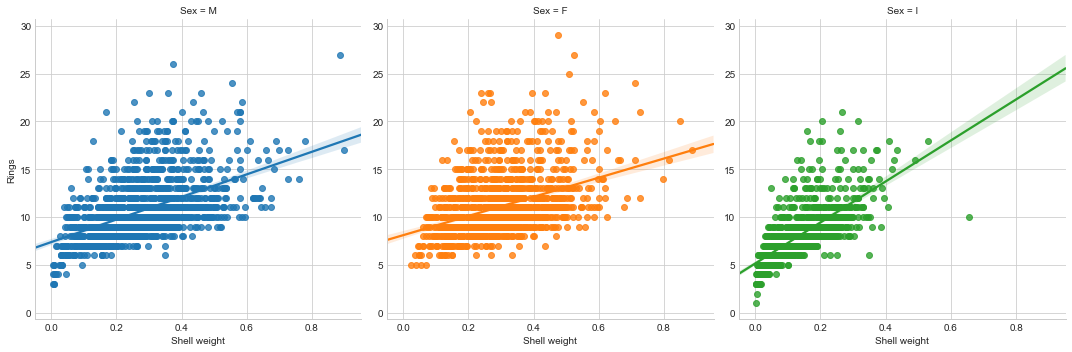

In [65]:
# Since Rings has a high correlation with Shell weight, I would like to see the distubution of the Rings vs. Shell weight by sex. 
sns.set_style("whitegrid")
g = sns.FacetGrid(data, col="Sex", hue="Sex",margin_titles=True,size=5, aspect=1)
g.map(sns.regplot, "Shell weight", "Rings", order=1)

There're differences between each sex group, therefore I decide to analyse by sex. 

In [66]:
#Split data by sex
male = data.loc[data["Sex"]=="M","Sex":"Rings"]
female = data.loc[data["Sex"]=="F","Sex":"Rings"]
infant = data.loc[data["Sex"]=="I","Sex":"Rings"]
adult = data.loc[data["Sex"]!="I","Sex":"Rings"]

#### 2.2 Visulise distribution

In [67]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


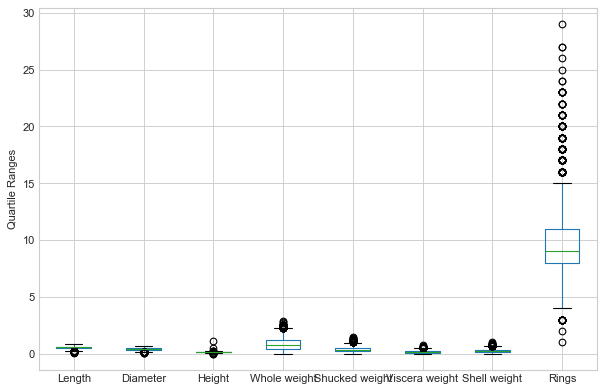

In [68]:
plt.figure(figsize=(9,6), dpi=80)
data.iloc[:,1:9].boxplot()
plt.ylabel(("Quartile Ranges"))
plt.show()

As we can see that the last column, rings, is out of the scale of the others, so plot again without it. 

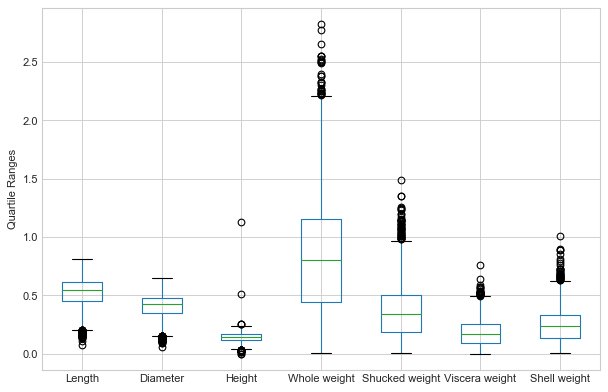

In [69]:
plt.figure(figsize=(9,6), dpi=80)
data.iloc[:,1:8].boxplot()
plt.ylabel(("Quartile Ranges"))
plt.show()

##### Take a look at of the distribution within each gender.

The distribution of Rings in the three genders:
       Rings                                                  Whole weight  \
      count       mean       std  min  25%   50%   75%   max        count   
Sex                                                                         
F    1307.0  11.129304  3.104256  5.0  9.0  10.0  12.0  29.0       1307.0   
I    1342.0   7.890462  2.511554  1.0  6.0   8.0   9.0  21.0       1342.0   
M    1528.0  10.705497  3.026349  3.0  9.0  10.0  12.0  27.0       1528.0   

                                                                      
         mean       std     min       25%      50%       75%     max  
Sex                                                                   
F    1.046532  0.430316  0.0800  0.730000  1.03850  1.320250  2.6570  
I    0.431363  0.286275  0.0020  0.205500  0.38400  0.599375  2.0495  
M    0.991459  0.470581  0.0155  0.671625  0.97575  1.265625  2.8255  


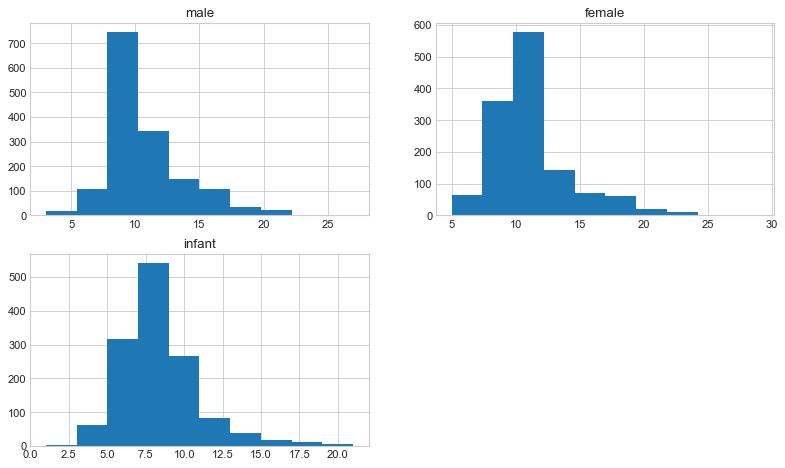

In [70]:
plt.figure(figsize=(12,7), dpi=80)
plt.subplot(2,2,1)
plt.title("male")
data.loc[data['Sex']=='M','Rings'].hist()

plt.subplot(2,2,2)
plt.title("female")
data.loc[data['Sex']=='F','Rings'].hist()

plt.subplot(2,2,3)
plt.title("infant")
data.loc[data['Sex']=='I','Rings'].hist()
print("The distribution of Rings in the three genders:\n",data.groupby('Sex')[["Rings",'Whole weight']].describe())
plt.show()

Observations:

(1) There are differences in distribution of Ring numbers in each category M, F & I.

However, the differences between ring numbers F & M are smaller, major difference in adult and infant. 

(2)  The rings differences between adult and infant is smaller than that of weight. It means that the the adults are as twice as heavy as infant, however number of rings are not that different. E.g. the median of infant weight is less than half of that of adult weight. However, the median of infant rings is only 20% less than adult. 

With the increase of weight, rings doesn't increase as much. (probably follow a log curve when x >1) 

In [71]:
# Count how many samples are in each sex group
data.groupby("Sex")['Sex'].count()

Sex
F    1307
I    1342
M    1528
Name: Sex, dtype: int64

It's good to see that there are similar number of samples in each category.

### 3. Linear regression

#### 3.1 Create Dummy variables for Sex column.

In [72]:
data_num = pd.get_dummies(data,drop_first=True)  #prefix=['M','F','I']
data_num.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0


#### 3.2 Define linear regression function

In [73]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def linear_regression(df,feature_cols,y_col,test_size,random_state):
    
    X = df[feature_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print("No. (samples, features) in training predictors:",X_train.shape)
    print("No. samples in training response:", y_train.shape)
    print("No. (samples, features) in test predictors:", X_test.shape)
    print("No. samples in testing response:", y_test.shape)
    
    # instantiate
    linreg = LinearRegression()

    # fit the model to the training data (learn the coefficients)
    linreg.fit(X_train, y_train)

    # print the intercept and coefficients
    print("beta0",linreg.intercept_)

    # pair the feature names with the coefficients
    print(pd.DataFrame({"features":feature_cols,"coef":linreg.coef_.tolist()}))
    #list(zip(feature_cols, linreg.coef_))
        
    
    # make predictions on the testing set
    y_pred = linreg.predict(X_test)
    # to calculate training r2
    y_hat = linreg.predict(X_train)
    
    # evaluate the model by testing errors.
    mse_test = metrics.mean_squared_error(y_test,y_pred)
    print("MSE_test: %.2f"% mse_test)
    r2_train = metrics.r2_score(y_train,y_hat)
    print('R2_train: %.2f' % r2_train)
    r2_test = metrics.r2_score(y_test,y_pred)
    print('R2_test: %.2f' % r2_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('RMSE: %.2f' % rmse_test)
    mae_test = metrics.mean_absolute_error(y_test, y_pred)
    print('MAE: %.2f' % mae_test)
    
    #RMSE has the benefit of penalizing large errors more, but in this case MAE is more reasonable
    
    return y_test, y_pred, mse_test, r2_test, rmse_test

# Plot the residule to ovbserve the non-linearality 
def plot_residual(y_test,y_pred,name):
    residual = y_test - y_pred
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    # Plot the residual vs. predicted value to observe if the right type of equation is used, and if Variance is constant.
    #print(len(y_test),len(y_pred))
    ax1.scatter(x=y_pred, y=residual)
    ax1.set_title('Residual VS y_pred %s' %name)
    ax1.set_xlabel('predicted values (Number of Rings)')
    ax1.set_ylabel('Residual')

    # Error terms should have a Normal Distribution
    ax2.hist(residual)
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Frequency')

#### Linear Regression with data from all three sex, sex is converted to dummy variables

No. (samples, features) in training predictors: (3341, 9)
No. samples in training response: (3341,)
No. (samples, features) in test predictors: (836, 9)
No. samples in testing response: (836,)
beta0 3.84115008942
        coef        features
0   0.066819           Sex_M
1  -0.782574           Sex_I
2  -0.968322          Length
3  12.064288        Diameter
4   9.650868          Height
5   8.747801    Whole weight
6 -19.871623  Shucked weight
7  -9.776740  Viscera weight
8   9.179279    Shell weight
MSE_test: 4.77
R2_train: 0.54
R2_test: 0.51
RMSE: 2.18
MAE: 1.58


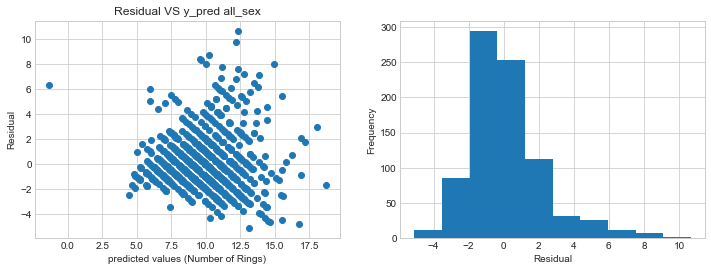

In [74]:
feature_cols = ["Sex_M","Sex_I",'Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
y_test, y_pred, mse_test, r2_test, rmse_test = linear_regression(data_num,feature_cols,"Rings",0.2,1)
plot_residual(y_test,y_pred,"all_sex")

#### Linear Regression model by Sex

#####  Male

No. (samples, features) in training predictors: (1222, 7)
No. samples in training response: (1222,)
No. (samples, features) in test predictors: (306, 7)
No. samples in testing response: (306,)
beta0 4.93972099005
        coef        features
0   0.320992          Length
1   4.216667        Diameter
2  17.214188          Height
3   8.060665    Whole weight
4 -18.425955  Shucked weight
5  -9.693055  Viscera weight
6  11.310548    Shell weight
MSE_test: 5.35
R2_train: 0.44
R2_test: 0.42
RMSE: 2.31
MAE: 1.75


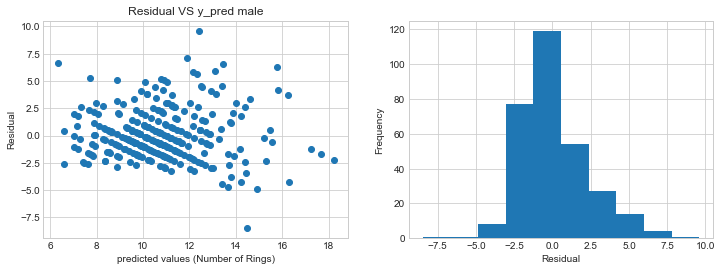

In [75]:
feature_cols = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
y_test_m, y_pred_m, mse_test, r2_test, rmse_test = linear_regression(male,feature_cols,"Rings",0.2,1)
plot_residual(y_test_m,y_pred_m,"male")

#####  Female

No. (samples, features) in training predictors: (1045, 7)
No. samples in training response: (1045,)
No. (samples, features) in test predictors: (262, 7)
No. samples in testing response: (262,)
beta0 9.10202604442
        coef        features
0  -9.728332          Length
1  10.688737        Diameter
2   2.349854          Height
3  10.807899    Whole weight
4 -21.365335  Shucked weight
5  -7.877741  Viscera weight
6   8.260758    Shell weight
MSE_test: 6.00
R2_train: 0.36
R2_test: 0.33
RMSE: 2.45
MAE: 1.85


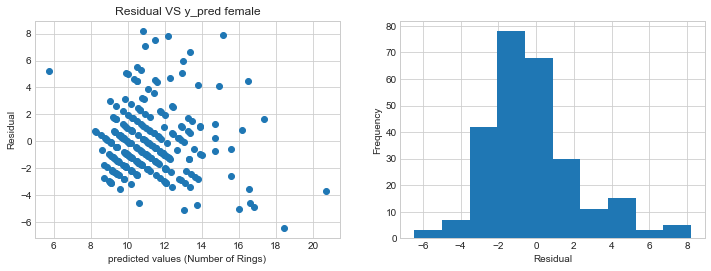

In [76]:
feature_cols = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
y_test_f, y_pred_f, mse_test, r2_test, rmse_test = linear_regression(female,feature_cols,"Rings",0.2,1)
plot_residual(y_test_f,y_pred_f,"female")

##### Infant

No. (samples, features) in training predictors: (1073, 7)
No. samples in training response: (1073,)
No. (samples, features) in test predictors: (269, 7)
No. samples in testing response: (269,)
beta0 3.47486663728
        coef        features
0  -5.838208          Length
1   6.572946        Diameter
2  29.700730          Height
3   6.023528    Whole weight
4 -11.140371  Shucked weight
5  -7.835148  Viscera weight
6  13.988363    Shell weight
MSE_test: 3.38
R2_train: 0.61
R2_test: 0.46
RMSE: 1.84
MAE: 1.25


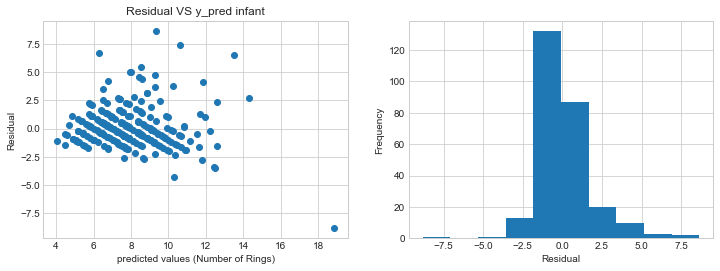

In [77]:
feature_cols = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
y_test_i, y_pred_i, mse_test, r2_test, rmse_test = linear_regression(infant,feature_cols,"Rings",0.2,1)
plot_residual(y_test_i,y_pred_i,"infant")

##### Adult

No. (samples, features) in training predictors: (2268, 7)
No. samples in training response: (2268,)
No. (samples, features) in test predictors: (567, 7)
No. samples in testing response: (567,)
beta0 5.91498878778
        coef        features
0  -2.701341          Length
1   9.397757        Diameter
2   6.430156          Height
3   9.366979    Whole weight
4 -19.405001  Shucked weight
5 -10.967780  Viscera weight
6   9.429261    Shell weight
MSE_test: 5.46
R2_train: 0.40
R2_test: 0.39
RMSE: 2.34
MAE: 1.76


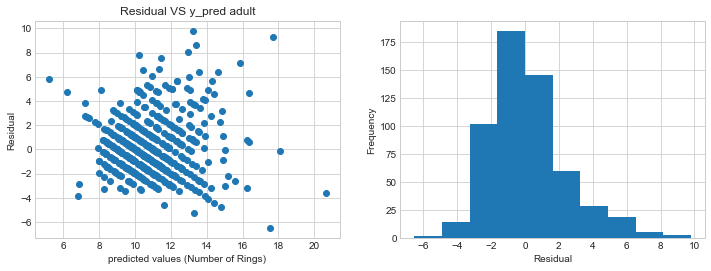

In [78]:
feature_cols = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
y_test_a, y_pred_a, mse_test, r2_test, rmse_test = linear_regression(adult,feature_cols,"Rings",0.2,1)
plot_residual(y_test_a,y_pred_a,"adult")

Observation: 

(1) The R2 is not very high for all three models, meaning only 51% of variance is explained. 

(2) The model fits best the training model in Infant category, with an R2 train of 0.61, also the testing mse in that category is relatively low. 

Improvement method:

(1) Linear regression is sensitive to correlated variables. I'll first try to remove some of the highly correlated ones. 

(2) If improvement is not obvious, then a model with more non-linearality is needed.

### 4. Improving linear regression model

#### 4.1 Try to remove or combine features with high correlation and not increasing much in RAE (LR Model 2)

First observe the result of linear regression with all sex data. 

        coef        features
    0   0.066819           Sex_M
    1  -0.782574           Sex_I
    2  -0.968322          Length
    3  12.064288        Diameter
    4   9.650868          Height
    5   8.747801    Whole weight
    6 -19.871623  Shucked weight
    7  -9.776740  Viscera weight
    8   9.179279    Shell weight
    
    MSE_test: 4.77
    R2_train: 0.54
    R2_test: 0.51
    RMSE: 2.18
    MAE: 1.58
    
My strategy of choosing variables:

(1) Amoung the four weights, which are all highly correlated, I picked one with positive coeficient and the other one with negative. 

(2) Recall the observation from previous section that the main distribution difference lies between adult and   infant, not male and female. Therefore, only dummy variable Sex_I is included. Later experiments proved my guess, adding Sex_M almost doesn't improve the model at all. 

No. (samples, features) in training predictors: (3341, 4)
No. samples in training response: (3341,)
No. (samples, features) in test predictors: (836, 4)
No. samples in testing response: (836,)
beta0 4.02049656967
        coef        features
0  -0.909194           Sex_I
1  13.289364        Diameter
2  20.827036    Shell weight
3 -11.698314  Shucked weight
MSE_test: 5.07
R2_train: 0.52
R2_test: 0.48
RMSE: 2.25
MAE: 1.62


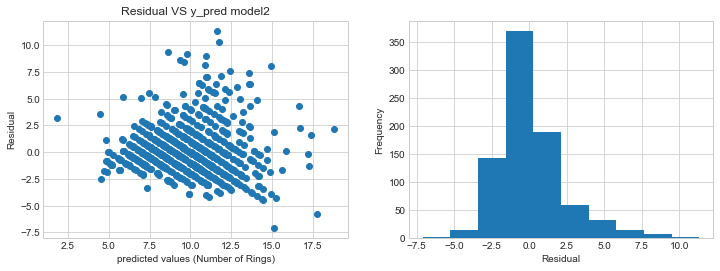

In [79]:
#Model 2
feature_cols_2 = ["Sex_I","Diameter","Shell weight","Shucked weight"] 
y_test_2, y_pred_2, mse_test, r2_test, rmse_test = linear_regression(data_num,feature_cols_2,"Rings",0.2,1)
plot_residual(y_test_2,y_pred_2,"model2")

Observations:

(1) After experimenting with and without dummy variable Sex_M, adding Sex_M had negligible effect on the model.Only distinguishing whether it's an adult is enough.

(2) "Height","length","Viscera weight","Whole weight" are highly correlated with diameter and other types of weight, so they can be removed. Compare with the first model with all the features, this model's MAE increased only from 1.58 to 1.62.

(3) All the models tend to have a similar type of residual. There must be something else that I haven't discovered! Some part of the variance still remians to be unexplained

#### 4.2 Creating possible new features. (LR Model 3)

My strategy to create new features:

Recall the observation in 2.2, with the increase of weight, rings doesn't increase as much. Also from the pairplot, observed that the weight has a log-pattern influence on number of rings.(a log curve when x >1)

In [80]:
# Height has large variance and doesn't influence much on the result. It was not included at the end. 
data_num.loc[:,'height_sqr'] = data_num['Height'].apply(lambda x:x**2)

# some adjustment to mimic the pattern observed in scatter plot. Use log function however transform data to positive values.
data_num.loc[:,'log_shell_weight'] = data_num.loc[:,'Shell weight'].apply(lambda x:np.log(100*x)/10)
data_num.loc[:,'log_shucked_weight'] = data_num.loc[:,"Shucked weight"].apply(lambda x:np.log(100*x)/10)

#a quadratic pattern in length and diameter
data_num.loc[:,'size'] = [a*b for a,b in zip(data['Length'],data['Diameter'])]

data_num.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_I,Sex_M,height_sqr,log_shell_weight,log_shucked_weight,size
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,1,0.009025,0.270805,0.311129,0.166075
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,1,0.008100,0.194591,0.229757,0.092750
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0,0,0.018225,0.304452,0.324454,0.222600
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,1,0.015625,0.274084,0.307038,0.160600
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,0,0.006400,0.170475,0.219165,0.084150


No. (samples, features) in training predictors: (3341, 4)
No. samples in training response: (3341,)
No. (samples, features) in test predictors: (836, 4)
No. samples in testing response: (836,)
beta0 4.48486270252
        coef            features
0  -0.701175               Sex_I
1   5.255170            Diameter
2  61.492254    log_shell_weight
3 -43.815785  log_shucked_weight
MSE_test: 4.91
R2_train: 0.52
R2_test: 0.50
RMSE: 2.22
MAE: 1.58


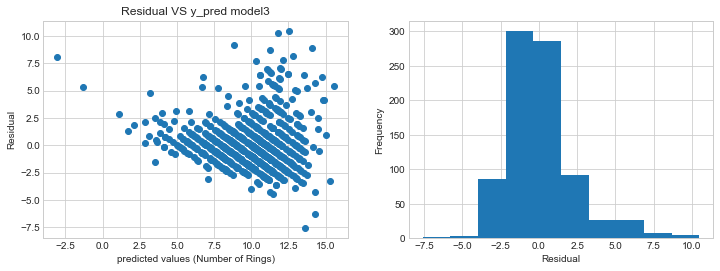

In [81]:
#Model 3
feature_cols_3 =["Sex_I","Diameter","log_shell_weight","log_shucked_weight"] 
y_test_3, y_pred_3, mse_test, r2_test, rmse_test = linear_regression(data_num,feature_cols_3,"Rings",0.2,1)
plot_residual(y_test_3,y_pred_3,"model3")

* Observation:

Compare this model with the very first model that predict with all features on all sex. 

    First model: all_sex data, all 9 features
    ["Sex_M","Sex_I",'Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    MSE_test: 4.77
    R2_train: 0.54
    R2_test: 0.51
    RMSE: 2.18
    MAE: 1.58

    This model: Model 3, 4 features
    ["Sex_I","Diameter","log_shell_weight","log_shucked_weight"]
    MSE_test: 4.91
    R2_train: 0.52
    R2_test: 0.50
    RMSE: 2.22
    MAE: 1.58


(1) After selecting and combining/transforming some features, with much less features (4 instead of 9), MAE remains the same and both train and test R2 stay almost the same. This is model is easier to interpret. I managed to select the useful features in this step. 

(2) This model is better also because the residual distrubution is much more close to normal distribution that has a mean close to zero. In previous models, the residual has a negative mean.

(3) This model seems to perform better when number of rings are relatively small (probably infant). 

(3) I'll explore options beyond Linear Models.


* Future improvements methods:

Due to the distribution of the residuals, I would like to do a hypothesis test to verify if there is evidence to reject null hypothesis. 

If there's a linear relationship, I'll try lasso and ridge regression for better feature selection.

I'll also try PCA, which works especially good for features that has high collinearality. 

#### Regularization method for feature selection

#### PCA for dimension reduction

### KNN 

#### Using cross-validation to select the best K (with lowest MSE)

In [82]:
from sklearn.cross_validation import KFold
m = len(data)  #total number of samples
kf = KFold(m, n_folds=5, shuffle=False)
for iteration, data in enumerate(kf, start=1):
    print(str(iteration)+"\n","Training set",data[0].shape,"Testing set",data[1].shape)

1
 Training set (3341,) Testing set (836,)
2
 Training set (3341,) Testing set (836,)
3
 Training set (3342,) Testing set (835,)
4
 Training set (3342,) Testing set (835,)
5
 Training set (3342,) Testing set (835,)


In [83]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score
k_range = list(range(1, 31))
k_mse = []
k_best = 1
# X is all the feature data
X = data_num[["Sex_M","Sex_I",'Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']]
# y is the response column
y = data_num["Rings"]
for k in k_range:
    #scores = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
    scores_k = []
    for iteration, data in enumerate(kf, start=1):
        knn = KNeighborsRegressor(n_neighbors = k)
        x_train_thisfold = X.iloc[data[0],:]
        y_train_thisfold = y[data[0]]
        x_test_thisfold = X.iloc[data[1],:]
        y_test_thisfold = y[data[1]]
        
        knn.fit(x_train_thisfold, y_train_thisfold)
        y_pred_thisfold = knn.predict(x_test_thisfold)
        scores_thisfold = metrics.mean_squared_error(y_test_thisfold,y_pred_thisfold)
        scores_k.append(scores_thisfold)
        mse_this_k = sum(scores_k)/float(len(scores_k))
    k_mse.append(mse_this_k)
print(k_mse)

[8.4823370483912566, 6.6837309113829759, 5.8913891515215182, 5.6376478562014727, 5.4927698249434149, 5.3552405794471669, 5.3182206312889306, 5.2979888100593069, 5.2588272754508694, 5.2388776466206348, 5.220172314629707, 5.2208584306665777, 5.2333811271033994, 5.236031807101547, 5.2342963221881593, 5.2568715305632754, 5.2540353051616018, 5.2606053001210054, 5.2698834538110102, 5.2605398669168846, 5.2808027131623545, 5.2981160438030974, 5.3122117722207918, 5.3125948521617046, 5.3296731224250058, 5.3372505355925561, 5.3474886834125082, 5.3572354830179503, 5.3647953378384523, 5.3752773311431365]


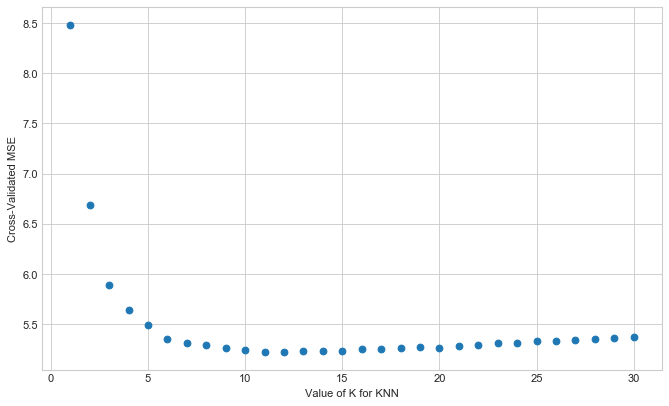

In [84]:
plt.figure(figsize=(10,6), dpi=80)
plt.scatter(x = k_range, y = k_mse)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

k = 11 has the smallest CV MSE, therefore is the best. Now we're going to use knn model with k=11 to train and test our data

In [85]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=11)

# Split the training and testing set with the same random seed as linear regression.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit the model on the training data.
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [86]:
# Compute the mean squared error of our predictions.
mse_knn = (((y_pred_knn - y_test) ** 2).sum()) / len(y_pred_knn)
print("MSE: %.2f"% mse_knn)

MSE: 4.78


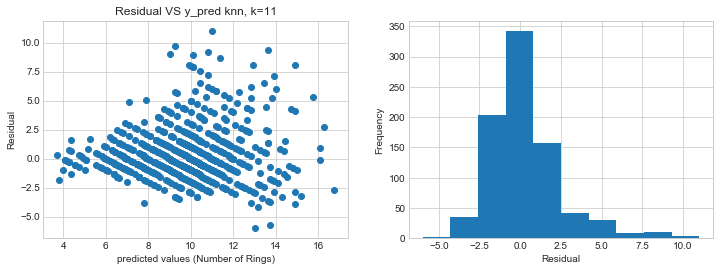

In [87]:
plot_residual(y_test,y_pred_knn,"knn, k=11")

Obeservation and thoughts:
Knn performs a little bit better than linear regression. 

(1). Comparing to linear regression, the residule is more close to a normal distribution. It seems to be like a f-statistic distribution shale, similar than the distrubution pattern of all four types of weight. (the diagnoal of the pariplot)


(2). In the left figure: Residual vs. predicted value, the distribution is more uniform, i.e. the difference between low predicted value and high predicted value, is smaller than linear regression.

### Tree Regression

In [88]:
from sklearn.tree import DecisionTreeRegressor

# create an estimator, optionally specifying parameters
tr_model = DecisionTreeRegressor()

# fit the estimator to the data
tr_model.fit(X_train, y_train)

# apply the model to the test and training data
y_pred_tr = tr_model.predict(X_test)
y_pred_train_tr = tr_model.predict(X_train)

In [89]:
def scatter_y(y_true,y_pred,title):

    fig = plt.figure(figsize=(8,8))
    plt.scatter(y_true,y_true)
    plt.scatter(y_true,y_pred)
    plt.xlabel('Actual Rings')
    plt.ylabel("Predicted Rings")
    plt.title(title,fontsize=16)
    plt.show()

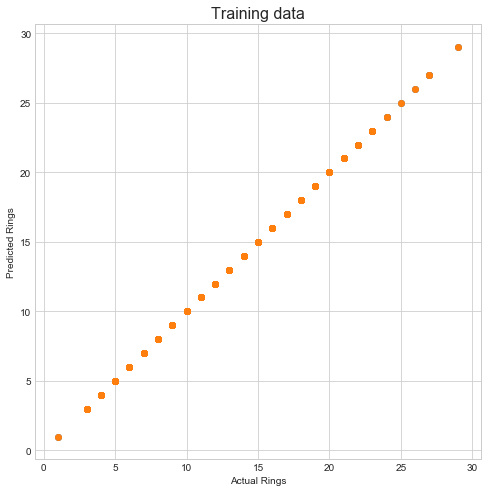

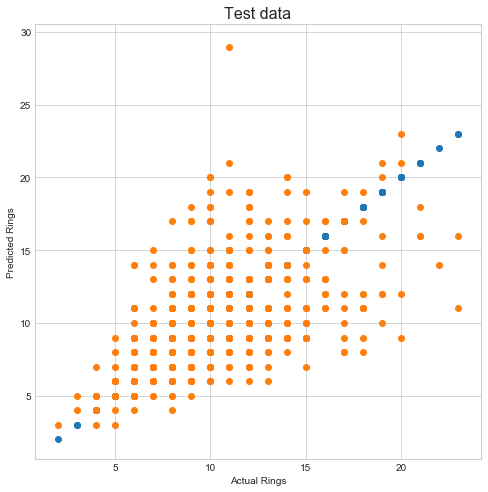

In [90]:
scatter_y(y_train, y_pred_train_tr,"Training data")
scatter_y(y_test, y_pred_tr,"Test data")

In [91]:
# evaluate the model by testing errors.
mse_test = metrics.mean_squared_error(y_test,y_pred_tr)
print("MSE_test: %.2f"% mse_test)

mse_train = metrics.mean_squared_error(y_train,y_pred_train_tr)
print('MSE_train: %.2f' % mse_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_tr))
print('RMSE: %.2f' % rmse_test)

mae_test = metrics.mean_absolute_error(y_test, y_pred_tr)
print('MAE: %.2f' % mae_test)

MSE_test: 8.41
MSE_train: 0.00
RMSE: 2.90
MAE: 1.98


Obervation:

(1) The Decision Tree overfits the training set. The parameters are fine tuned to reproduce the results of the training set, but has high variance on new dataset.

(2) To prevent this issue we specify a maximum depth of the decision tree of  15 , so that the estimator does not "specialize" too much on the training data

In [92]:
tr_model2 = DecisionTreeRegressor(max_depth=10)

# fit the estimator to the data
tr_model2.fit(X_train, y_train)

# apply the model to the test and train data
y_pred_tr_2 = tr_model2.predict(X_test)
y_pred_train_tr_2 = tr_model2.predict(X_train)

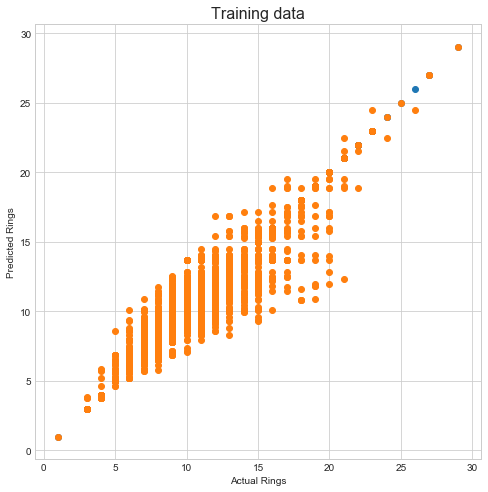

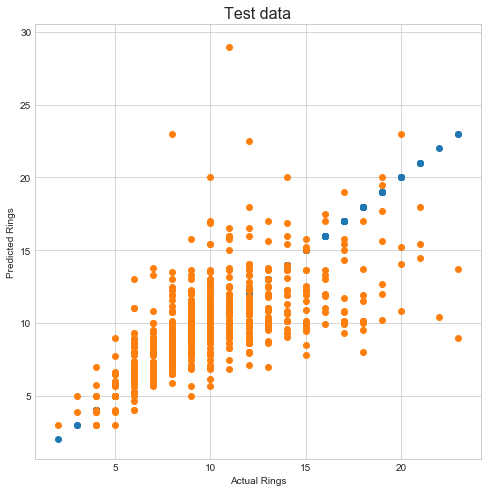

In [93]:
scatter_y(y_train, y_pred_train_tr_2,"Training data")
scatter_y(y_test, y_pred_tr_2,"Test data")

In [94]:
# evaluate the model by testing errors.
mse_test = metrics.mean_squared_error(y_test,y_pred_tr_2)
print("MSE_test: %.2f"% mse_test)

mse_train = metrics.mean_squared_error(y_train,y_pred_train_tr_2)
print('MSE_train: %.2f' % mse_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_tr_2))
print('RMSE: %.2f' % rmse_test)

mae_test = metrics.mean_absolute_error(y_test, y_pred_tr_2)
print('MAE: %.2f' % mae_test)

MSE_test: 6.77
MSE_train: 1.79
RMSE: 2.60
MAE: 1.73


Observation: 

RMSE decreased compared with the first tree model. It improved the overfitting problem. 

### Random Forest with cross validation

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

# Find the optimal number of trees by cross-validation
scores = pd.DataFrame()
for n in range(1,31):
    RF = RandomForestRegressor(n_estimators=n, max_depth=None, min_samples_split=2, random_state=0)
    score = cross_val_score(RF, X_train, y_train,cv=10)
    scores[n] = score

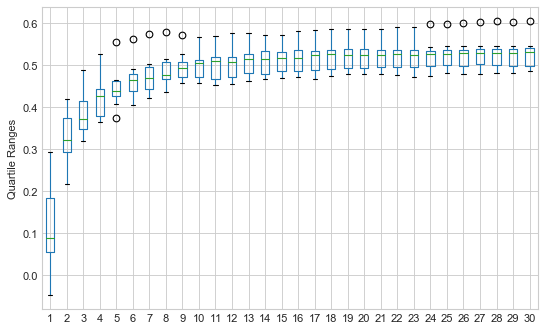

In [96]:
plt.figure(figsize=(8,5), dpi=80)
scores.boxplot()
plt.ylabel(("Quartile Ranges"))
plt.show()

Choose number of trees as 20.

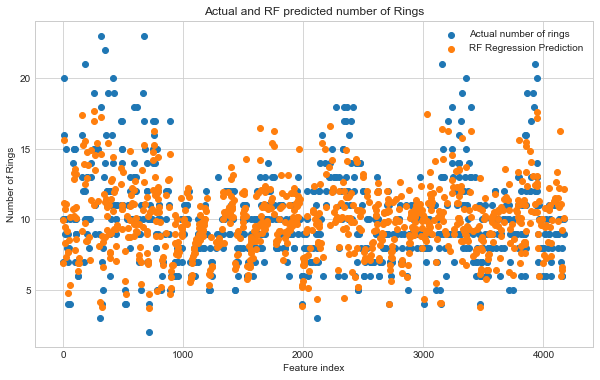

In [97]:
# Use the optimal number of trees for prediction:
RF = RandomForestRegressor(n_estimators=20, max_depth=None, min_samples_split=2, random_state=0)
RF.fit(X_train,y_train)
y_pred_rf = RF.predict(X_test)
y_hat_rf = RF.predict(X_train)

fig,ax = plt.subplots(1, 1,figsize=(10,6))
line1 =plt.scatter(X_test.index, y_test, label='Actual number of rings')
line2 =plt.scatter(X_test.index, y_pred_rf, label='RF Regression Prediction')
plt.xlabel('Feature index')
plt.ylabel('Number of Rings')
plt.title('Actual and RF predicted number of Rings')
plt.legend([line1, line2], ['Actual number of rings', 'RF Regression Prediction'])
plt.show()

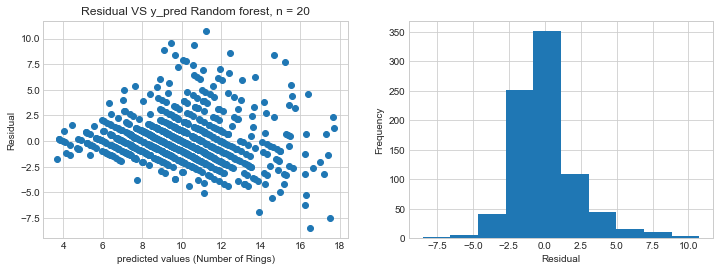

In [98]:
plot_residual(y_test,y_pred_rf,"Random forest, n = 20")

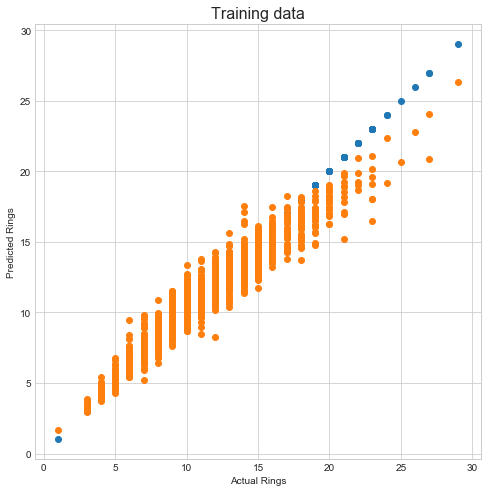

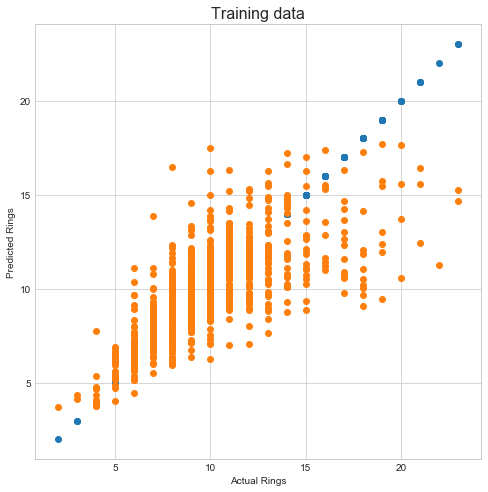

In [99]:
scatter_y(y_train,y_hat_rf,"Training data")
scatter_y(y_test,y_pred_rf,"Training data")

In [100]:
# evaluate the model by testing errors.
mse_test = metrics.mean_squared_error(y_test,y_pred_rf)
print("MSE_test: %.2f"% mse_test)

mse_train = metrics.mean_squared_error(y_train,y_hat_rf)
print('MSE_train: %.2f' % mse_train)

rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE: %.2f' % rmse_test)

mae_test = metrics.mean_absolute_error(y_test, y_pred_rf)
print('MAE: %.2f' % mae_test)

MSE_test: 5.03
MSE_train: 0.79
RMSE: 2.24
MAE: 1.59


Observation:

(1). Random forest has a very low training mse and also a relatively low test MSE. It improved a lot the overfitting problem than tree regression.

(2). Random forest is a fair model to use. Compared with Tree Regression, RMSE of Random forest reduced from 2.6 to 2.2. 

### Summary

* Data visualisation:
    - Rings positively correlated with all the quantitative features.
    - features highly correlated
    - rings vs. weight has a log pattern
    - Difference distribution between adult and infant, similar in male and female


* Methods used:

    - Linear Regression: Performed feature selection:
        - Train model both on all data and on each sex category.
        - feature selection, remove some highly correlated features.
        - feature transformation, log shell weight and log shucked weight.
        - Comparing test MSE and RMSE, the feature selection has made the model more interpretable while keeping the same level of prediction accuracy.
        - Future exploration and improvement methods: Hypothesis test, Lasso & PCA
      
    - KNN
        - Cross validation selected best K
        - The test MSE is similar than that of linear regression.
        - Residual's distribution is better
    
    - Tree Regression
        - Obvious overfitting is reduced by limiting the number of trees. 
    
    - Random forest    
        - Cross validation to select the best number of trees. 
        - The residual distribution is the most uniform amoung all the models, meaning variance is reduced. The strong correlation between the normal decision trees are largely avoided.  
        - Overfitting is largely improved. 



* Future improvements:
    - Classification methods, SVM or Logistic regression.
    - Regularization methods, Lasso & Ridge.
    - PCA